# Output analysis of inventory simulation model


This notepook can be used as a tutorial for outplut analysis for a terminating simulation model. It builds on the inventory simulation model saved in this repository.

Check the README file for details on how the simulation model works.

## Table of contents

1. [Using the simulation model](#usingmodel)
2. [Output analysis of a terminating simulation](#terminatingsim)  
    2.1 [Building a confidence interval for total inventory cost](#confidenceinterval)
3. [Minimizing inventory costs](#optim)  
    3.1 [Generating a contour plot](#contourplot)   
    3.2 [Generating a response surface](#responsesurface)

 ## 1. Using the simulation model
 <a id="usingmodel"></a>

In [1]:
import numpy as np
import model

To run a single iteration of the inventory simulation model, use the run function of the model.py file. User will need to enter:

- a simulation length (expressed in days) after which the simulation stops
- a reorder point specifying the inventory level (in units) that triggers an order to replenish the stocks 
- an order size specifying the number of units to order

The function will return a dictionary containing user input parameters (reorder point, order size) and the model output (average monthly total inventory cost, ordering cost, shortage cost and holding cost).

Let's run a few iterations and analyze their output:

In [2]:
# perform a single run of the inventory simulation model
model.run(length = 120., reorder_point = 20, order_size = 20)

{'reorder_point': 20,
 'order_size': 20,
 'total_cost': 123.5,
 'ordering_cost': 95.4,
 'holding_cost': 9.2,
 'shortage_cost': 18.9}

In [3]:
# run alternative configuration of the model with increased order size
model.run(length = 120., reorder_point = 20, order_size = 80)

{'reorder_point': 20,
 'order_size': 80,
 'total_cost': 126.4,
 'ordering_cost': 82.5,
 'holding_cost': 36.5,
 'shortage_cost': 7.4}

In these two iterations, we maintained the same reorder point and increased the order size from 20 to 80 units. 

This resulted in lower shortage cost (since bigger orders are placed) and lower ordering costs (orders are not placed as frequently). Holding costs predictably increased because larger inventory levels were maintained.

In terms of total costs, the second configuration isn't as good as the first one.

In [4]:
# run alternative configuration with smaller reorder point
model.run(length = 120., reorder_point = 10, order_size = 20)

{'reorder_point': 10,
 'order_size': 20,
 'total_cost': 129.5,
 'ordering_cost': 91.7,
 'holding_cost': 4.4,
 'shortage_cost': 33.4}

In this configuration, the reorder point was lowered. This reduced the average holding costs (because a smaller inventory is being maintained) at the expense of a large increase in shortage cost.

This configuration is so far the worst of the three in terms of total costs.

 <a id="terminatingsim"></a>
## 2. Output analysis of a terminating simulation

In this section, we'll simulate an inventory system with a 30 units reorder point and an order size of 60 units. We will estimate the avrerage monthly cost of this inventory policy after 120 months.

Since there is an event ending the simulation (after 120 months), the simulation will be analyzed as a terminating model (as opposed to analyzing steady state parameters for example).

In [5]:
# define simulation parameters
length = 120
reorder_point = 30
order_size = 60

# run independent replications
np.random.seed(1066)
first_run = model.run(length, reorder_point, order_size)
second_run = model.run(length, reorder_point, order_size)

# print results
print('First replication total costs:', first_run['total_cost'])
print('Second replication total costs:', second_run['total_cost'])

First replication total costs: 126.0
Second replication total costs: 127.2


The two independent replications of the model resulted in different total cost output, because of random variables embedded in the model. 
This means that a single run will not provide a definitive measure of total inventory cost. Instead, we can run several independent replications of the simulation to build a confidence interval for total inventory costs.

 <a id="confidenceinterval"></a>
### 2.1 Building a confidence interval for total inventory cost

In [8]:
import pandas as pd

np.random.seed(1066)  # generate random number sequence
length = 120.
num_replications = 15

df = pd.DataFrame(model.run_experiments(length, [reorder_point], [order_size], num_replications))
df

,reorder_point,order_size,total_cost,ordering_cost,holding_cost,shortage_cost
0,30,60,126.0,87.4,35.6,2.9
1,30,60,127.2,86.5,36.7,4.0
2,30,60,123.0,84.2,35.5,3.2
3,30,60,126.6,87.3,35.1,4.2
4,30,60,125.2,85.7,36.4,3.1
5,30,60,125.5,85.6,35.3,4.5
6,30,60,126.2,87.3,36.0,2.9
7,30,60,124.7,87.0,35.6,2.1
8,30,60,127.0,87.2,35.5,4.3
9,30,60,125.9,86.6,35.4,3.9


We then need to compute our sample mean and sample standard deviation of the total cost output.

Because our sample size is small (less than 30 observations is often used as a rule of thumb), we'll use a t-statistics (as opposed to a z-statistics) to build our confidence interval.

In [9]:
from scipy import stats
 
# compute sample mean and standard deviation
mean = df['total_cost'].mean()
std = df['total_cost'].std()

# compute t-statistics for a 90% confidence interval
alpha = 1-.9
tstat = stats.t.ppf(1-alpha/2, num_replications - 1)

# compute confidence interval
error_margin = tstat * std / np.sqrt(num_replications)
lbound = mean - error_margin
ubound = mean + error_margin

print("90 percent confidence interval for monthly inventory cost: [%.1f, %.1f]" % (lbound, ubound))

90 percent confidence interval for monthly inventory cost: [124.1, 126.0]


<a id="optim"></a>
## 3. Minimizing inventory costs

So far we have tested several configurations and built a confidence interval of their average cost output to determine which configuration is better.

In this section, we are going to explore the simulation model output to  determine the best combination of re-order point and order size that minimize the total monthly cost of the inventory system.

<a id="contourplot"></a>
### 3.1 Generating a contour plot

One way to find inputs combination that will optimize a response is to run several replications of the simulation model over a wide range of possible configuration and analyze each of the individual outputs.

You can run multiple configurations at once using the run_experiments function (see help below), or simply load the results.csv file that already contains the output dataset for the configurations we'll specify in this section.

In [11]:
help(model.run_experiments)

Help on function run_experiments in module model:

run_experiments(length, reorder_points, order_sizes, num_rep)
    Runs inventory simulation with every combination of reorder points and
    order sizes, and assembles results in a list of dictionaries
    
    Args:
        - length: length of the simulation, in months
        - reorder_points: list of reorder points parameters to simulate 
        - order_sizes:list of order size parameters to simulate
        - num_rep: number of replications to run for each design point



We're going to run all configurations with reorder points going from 0 to 100 order sizes of 5 to 100 with increments of 5. Each configuration will be run 10 times.

In [ ]:
# user inputs
length = 120
num_rep = 10    # number of replications for each design point
reorder_points = np.arange(0,105,5)  # [0, 5, 10, ..., 95, 100]
order_sizes = np.arange(5,105,5)     # [5, 10, 15, ..., 95, 100]

# initialize results data collection
results = model.run_experiments(length, reorder_points, order_sizes, num_rep) # this may take a few minutes to run
results = pd.DataFrame(results)

In [28]:
# load dataset as a data frame
results = pd.read_csv('results.csv')

# select relevant columns
data = results[['order_size', 'reorder_point', 'total_cost']]

# for each combination of order size and reorder point, compute average response
data = data.groupby(['reorder_point', 'order_size']).mean()

# reset data index and rename columns
data.reset_index(inplace = True)
data.columns = ['reorder_point', 'order_size', 'cost']

# pivot dataset
data = data.pivot('reorder_point', 'order_size')

In [33]:
# map values
X = data.columns.levels[1].values  # order sizes
Y = data.index.values # reorder points
Z = data.values # average total cost
Xi, Yi = np.meshgrid(X,Y)

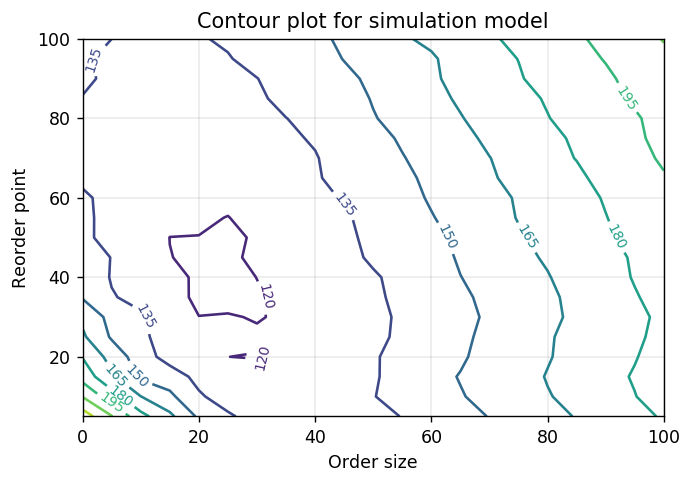

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

# generate contour plot
plt.figure(dpi=125)
plt.title('Contour plot for simulation model')
plt.xlabel('Order size')
plt.ylabel('Reorder point')
contours = plt.contour(Yi, Xi, Z, 10)
plt.clabel(contours, inline=True, fmt='%1.0f', fontsize=8)
plt.grid(color='gray', linestyle='-', linewidth=.15)
plt.show()

The contour plot shows us the expected average monthly total cost for each combination of order size and reorder point.

It seems that the minimum cost of the inventory system is between 110 and 120. It is reached when the order size is approximately 25 units and the reorder point between 35 and 45.

As we increase the reorder point and order size, the cost of the system rises steadily, due to greater holding costs. In the opposite corner, lowering the reorder point and order sizes creates a dramatic increase in total cost, due to frequent shortage of items.

<a id="responsesurface"></a>
### 3.2 Generating a response surface

The output of the simulation model can also be visualized as a 3D response surface. It really is a matter of personal preference. Let's use the same dataset and create a new visualization.

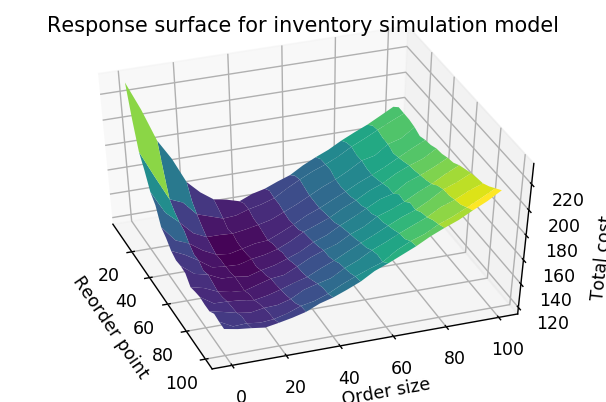

In [86]:
from mpl_toolkits import mplot3d

# generate response surface
fig = plt.figure(dpi = 125)
ax = plt.axes(projection='3d')
ax.plot_surface(Xi, Yi, Z, 
                rstride=2 , cstride=2,
                cmap='viridis', edgecolor = 'none')
ax.set_title('Response surface for inventory simulation model')
ax.set_xlabel('Reorder point')
ax.set_ylabel('Order size')
ax.set_zlabel('Total cost')
ax.view_init(45, -20)